In [151]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from numpy import sqrt, sin, cos, pi, cosh, sinh, tanh, exp, linalg, log
from sympy import symbols, solve
import math
from  scipy.sparse.linalg import eigsh

In [152]:
def Gibbs(qtilde,x0,z):
  p = 0.5
  h = qtilde * x0 + sqrt(qtilde) * z
  return tanh(h)/(1 + exp(qtilde/2)*(1-2*p)/(2*p * cosh(h) ))

def Gauss(z):
  return exp(-z*z/2)/sqrt(2*pi)

def ExpectGibbsRad(qtilde):
  p = 0.5
  BOUNDS = 10
  #x0 = 1  
  av_fp = lambda z: Gauss(z) * p * (Gibbs(qtilde,1,z))**2
  av_plus, err = integrate.quad(av_fp, -BOUNDS, BOUNDS)
  #x0 = -1  
  av_fm = lambda z: Gauss(z) * p * (Gibbs(qtilde,-1,z))**2
  av_minus, err = integrate.quad(av_fm, -BOUNDS, BOUNDS)
  #x0 = 0
  av_fz = lambda z: Gauss(z) * (1-2*p) * (Gibbs(qtilde,0,z))**2
  av_zero, err= integrate.quad(av_fz, -BOUNDS, BOUNDS)
  return av_plus + av_zero + av_minus

def ExpectGibbs(qtilde,prior):
  if(prior == 'gaussian'):
        return 1 - 1/(qtilde + 1)
  elif prior == 'rademacher':
        return ExpectGibbsRad(qtilde)

def iterate(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22,prior):
  damping = 0.2
  term1 =  ExpectGibbs(Qtilde1,prior)
  term2 = ExpectGibbs(Qtilde2,prior)
  newQtilde1 = (rho1/Delta_11**2) * term1 + (rho2/Delta_12**2) * term2
  newQtilde2 = (rho1/Delta_12**2) * term1 + (rho2/Delta_22**2) * term2
  return (1-damping)*newQtilde1 + damping*Qtilde1, (1-damping)*newQtilde2 + damping*Qtilde2, np.sqrt((newQtilde1-Qtilde1)**2 + (newQtilde2-Qtilde2)**2)
def Solve_Q(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22,prior):
    convergence = 1000
    while (convergence > 1e-3):
        Qtilde1, Qtilde2, convergence = iterate(Qtilde1,Qtilde2, rho1, rho2, Delta_11, Delta_12, Delta_22, prior)
        
    return Qtilde1, Qtilde2

In [153]:
def optimal_curve(start, end, points, diag_scalar, off_diag_scalar, prior):

    rho1, rho2 = 0.5, 0.5

    MMSEVec = []
    paramvec = []

    param_range = np.linspace(start, end, points)

    for param in param_range:
      Delta11 = param
      Delta12 = off_diag_scalar * param 
      Delta22 = diag_scalar * param
    
      Qtilde1 = 1
      Qtilde2 = 1
    
      Qtilde1, Qtilde2 = Solve_Q(Qtilde1, Qtilde2, rho1, rho2, Delta11, Delta12, Delta22,prior)
      MMSEVec.append(1 - np.sqrt(rho1**2 * ExpectGibbs(Qtilde1,prior)**2 + 
                           2 * rho1 * rho2 *  ExpectGibbs(Qtilde1,prior) * ExpectGibbs(Qtilde2,prior) + 
                           rho2**2 * ExpectGibbs(Qtilde2,prior)**2))
      paramvec.append(param)
    
    return {'parameter': paramvec, 'mse': MMSEVec}


In [154]:
def create_two_blocks(dimension, size1, value11, value12, value22): 
    #Returns a symmetric matrix consisting of two blocks with prescribed values 
    delta = np.zeros((dimension, dimension))
    delta[:size1, :size1] = value11
    delta[size1:, :size1] = value12
    delta[:size1, size1:] = value12
    delta[size1:, size1:] = value22
    return delta

def create_two_blocks_collection(dimension, *, start, end, points, first_size, diag_scalar, off_diag_scalar):
    N = dimension
    parameter_range = np.linspace(start, end, points)
    delta_collection = []
    for parameter in parameter_range:
        delta_collection.append(create_two_blocks(N, first_size, parameter, 
                                                  off_diag_scalar * parameter, diag_scalar * parameter))
    return np.array(delta_collection)

def get_instance(dimension, prior, delta):
    #Returns a ground truth vector and the matrix corrupted by a gaussian noise according to the model
    if prior == 'gaussian':
        true_vector = np.random.normal(0,1, size = (dimension, 1))    
    elif prior == 'rademacher':
        true_vector = np.random.choice([-1,1], size = (dimension, 1))
        
    noise = np.triu(np.random.normal(0, 1, (dimension,dimension)))
    noise = noise + noise.T + np.diag(np.random.normal(0,1, dimension))
    
    corrupted_matrix = np.sqrt(1 / dimension) * true_vector @ true_vector.T + noise * delta

    return true_vector, corrupted_matrix

def get_mse(truth, estimate):
    truth = truth.flatten()
    estimate = estimate.flatten()
    return min(np.mean((truth - estimate)**2), np.mean((truth + estimate)**2)) #It is impossible to learn the sign

def denoiser_and_derivative(to_denoise, kappa, *, prior):
    if(prior == 'gaussian'):
        return to_denoise /(1 + kappa), 1 / (1 + kappa) 
    elif prior == 'rademacher':
        return np.tanh(to_denoise), (1 - np.tanh(to_denoise)**2)

def iterate_amp(precision = 1e-3, max_steps = 100, *, init, prior, Y, delta):
    
    N = Y.shape[0]
    
    previous_estimator = np.zeros((N, 1))
    estimator = np.copy(init)
    derivative = np.zeros(N) 
    
    converged = False
    
    for timestep in range(max_steps):   
        Onsager_term = np.mean(derivative)
        
        next_step = np.sqrt(1 / N) * (Y/delta) @ estimator - Onsager_term * previous_estimator
        kappa = np.array([np.mean((estimator / delta[j])**2) for j in range(N)]).reshape((N, 1)) 
        
        previous_estimator = np.copy(estimator)
        estimator, derivative = denoiser_and_derivative(next_step, kappa, prior = prior)
        
        step_difference = np.mean((estimator-previous_estimator)**2)
        
        if (timestep > 2) and (step_difference < precision):
            converged = True
            break
            
    if not converged:
        print("AMP didn't converge!")
    
    return estimator

def averaged_performance(seeds, dimension, initialisation = 'uninformed', *, prior, delta, algorithm):
    mse = []
    N = dimension
    for _ in range(seeds):
            
        # Generate an instance
        truth, Y = get_instance(dimension = dimension, 
                             prior = prior, 
                             delta = delta)
        if algorithm == 'spectral':
            values, vectors = np.linalg.eigh(Y/delta)
            max_index = list(abs(values)).index(max(abs(values)))
            estimate = np.array(vectors[:, max_index])
        else:
            
            init = 1e-3 * np.random.normal(0,1,(N,1)) 
            if initialisation == 'informed':
                init += truth 
       
            estimate = iterate_amp(init = init, 
                                 prior = prior, 
                                 Y = Y, 
                                 delta = delta)
        mse.append(get_mse(truth, estimate))
    return np.mean(mse)

def data(seeds, dimension, prior, delta_collection, algorithm):
    data = {'parameter': [], 'mse': []}
    for delta in delta_collection:
        parameter = delta[0][0]
        print("Computing with parameter = {}".format(parameter))
        mse = averaged_performance(seeds = seeds, dimension = dimension, 
                                   delta = delta, prior = prior, algorithm = algorithm)
        data['parameter'].append(parameter)
        data['mse'].append(mse)
    return data

def visualize (data_spectral, data_amp, data_optimal):
    fig, ax = plt.subplots(figsize = (12,10))
    
    plt.plot(data_optimal['parameter'], data_optimal['mse'], 
         '-y', label='Predicted MMSE', color='blue')
    plt.plot(data_spectral['parameter'], data_spectral['mse'], '.', label = 'Spectral', color = 'green')
    plt.plot(data_amp['parameter'], data_amp['mse'], '.', label = 'AMP', color = 'red')
    
    plt.xlabel('p')
    plt.ylabel('mse')
    plt.legend()

Computing with parameter = 0.002
Computing with parameter = 0.005754385964912281
Computing with parameter = 0.00950877192982456
Computing with parameter = 0.013263157894736841
Computing with parameter = 0.017017543859649122
Computing with parameter = 0.0207719298245614
Computing with parameter = 0.02452631578947368
Computing with parameter = 0.028280701754385962
Computing with parameter = 0.03203508771929824
Computing with parameter = 0.035789473684210524
Computing with parameter = 0.039543859649122805
Computing with parameter = 0.043298245614035086
Computing with parameter = 0.04705263157894737
Computing with parameter = 0.05080701754385965
Computing with parameter = 0.05456140350877193
Computing with parameter = 0.05831578947368421
Computing with parameter = 0.06207017543859649
Computing with parameter = 0.06582456140350877
Computing with parameter = 0.06957894736842105
Computing with parameter = 0.07333333333333333
Computing with parameter = 0.07708771929824561
Computing with parame

Computing with parameter = 0.6702807017543859
Computing with parameter = 0.6740350877192982
Computing with parameter = 0.6777894736842105
Computing with parameter = 0.6815438596491228
Computing with parameter = 0.6852982456140351
Computing with parameter = 0.6890526315789474
Computing with parameter = 0.6928070175438596
Computing with parameter = 0.6965614035087719
Computing with parameter = 0.7003157894736842
Computing with parameter = 0.7040701754385965
Computing with parameter = 0.7078245614035088
Computing with parameter = 0.711578947368421
Computing with parameter = 0.7153333333333333
Computing with parameter = 0.7190877192982456
Computing with parameter = 0.7228421052631578
Computing with parameter = 0.7265964912280701
Computing with parameter = 0.7303508771929824
Computing with parameter = 0.7341052631578947
Computing with parameter = 0.737859649122807
Computing with parameter = 0.7416140350877193
Computing with parameter = 0.7453684210526316
Computing with parameter = 0.7491228

Computing with parameter = 1.3460701754385964
Computing with parameter = 1.3498245614035087
Computing with parameter = 1.353578947368421
Computing with parameter = 1.3573333333333333
Computing with parameter = 1.3610877192982456
Computing with parameter = 1.3648421052631579
Computing with parameter = 1.3685964912280701
Computing with parameter = 1.3723508771929824
Computing with parameter = 1.3761052631578947
Computing with parameter = 1.379859649122807
Computing with parameter = 1.3836140350877193
Computing with parameter = 1.3873684210526316
Computing with parameter = 1.3911228070175439
Computing with parameter = 1.3948771929824562
Computing with parameter = 1.3986315789473684
Computing with parameter = 1.4023859649122807
Computing with parameter = 1.406140350877193
Computing with parameter = 1.4098947368421053
Computing with parameter = 1.4136491228070176
Computing with parameter = 1.4174035087719297
Computing with parameter = 1.421157894736842
Computing with parameter = 1.424912280

Computing with parameter = 0.5276140350877193
Computing with parameter = 0.5313684210526316
Computing with parameter = 0.5351228070175439
Computing with parameter = 0.5388771929824562
Computing with parameter = 0.5426315789473684
Computing with parameter = 0.5463859649122806
Computing with parameter = 0.5501403508771929
Computing with parameter = 0.5538947368421052
Computing with parameter = 0.5576491228070175
Computing with parameter = 0.5614035087719298
Computing with parameter = 0.5651578947368421
Computing with parameter = 0.5689122807017544
Computing with parameter = 0.5726666666666667
Computing with parameter = 0.576421052631579
Computing with parameter = 0.5801754385964912
Computing with parameter = 0.5839298245614035
Computing with parameter = 0.5876842105263158
Computing with parameter = 0.5914385964912281
Computing with parameter = 0.5951929824561404
Computing with parameter = 0.5989473684210526
Computing with parameter = 0.6027017543859648
Computing with parameter = 0.606456

Computing with parameter = 1.2034035087719297
Computing with parameter = 1.207157894736842
Computing with parameter = 1.2109122807017543
Computing with parameter = 1.2146666666666666
Computing with parameter = 1.2184210526315788
Computing with parameter = 1.2221754385964911
Computing with parameter = 1.2259298245614034
Computing with parameter = 1.2296842105263157
Computing with parameter = 1.233438596491228
Computing with parameter = 1.2371929824561403
Computing with parameter = 1.2409473684210526
Computing with parameter = 1.2447017543859649
Computing with parameter = 1.2484561403508772
Computing with parameter = 1.2522105263157894
Computing with parameter = 1.2559649122807017
Computing with parameter = 1.259719298245614
Computing with parameter = 1.2634736842105263
Computing with parameter = 1.2672280701754386
Computing with parameter = 1.2709824561403509
Computing with parameter = 1.2747368421052632
Computing with parameter = 1.2784912280701755
Computing with parameter = 1.28224561

<ipython-input-152-b4b047dab3c4>:4: RuntimeWarning: overflow encountered in exp
  return tanh(h)/(1 + exp(qtilde/2)*(1-2*p)/(2*p * cosh(h) ))
<ipython-input-152-b4b047dab3c4>:4: RuntimeWarning: invalid value encountered in double_scalars
  return tanh(h)/(1 + exp(qtilde/2)*(1-2*p)/(2*p * cosh(h) ))
<ipython-input-152-b4b047dab3c4>:4: RuntimeWarning: overflow encountered in cosh
  return tanh(h)/(1 + exp(qtilde/2)*(1-2*p)/(2*p * cosh(h) ))
<ipython-input-152-b4b047dab3c4>:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  av_plus, err = integrate.quad(av_fp, -BOUNDS, BOUNDS)
<ipython-input-152-b4b047dab3c4>:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  av_minus, err = integrate.quad(av_fm, -BOUNDS, BOUNDS)
<ipython-input-152-b4b047dab3c4>:20: I

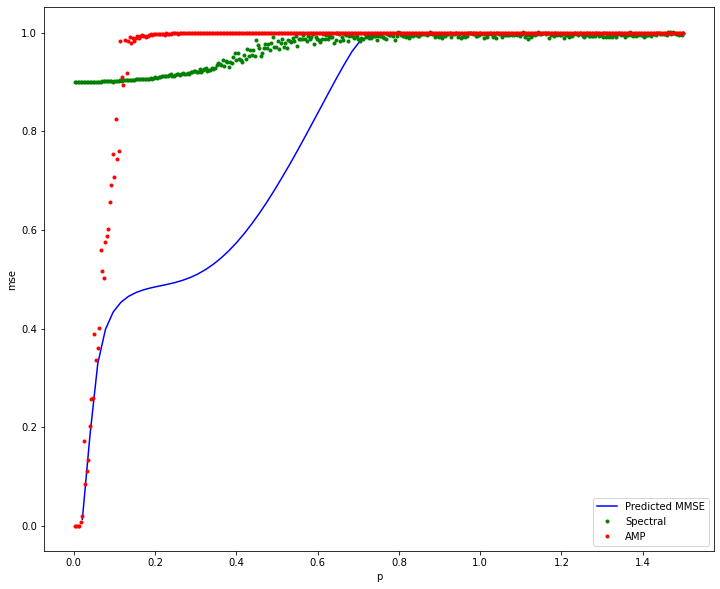

In [155]:
dimension = 200
start = 0.002
end = 1.5
points = 400
prior = 'rademacher'
diag_scalar = 20
off_diag_scalar = 20
delta_collection = create_two_blocks_collection(dimension = dimension, start = start, end = end, points = points, 
                                         first_size = dimension//2, diag_scalar = diag_scalar, 
                                                off_diag_scalar = off_diag_scalar)

amp_curve = data (seeds = 7, dimension = dimension,
                                   delta_collection = delta_collection, prior = prior, algorithm = 'amp')
spectral_curve = data (seeds = 7, dimension = dimension,
                                   delta_collection = delta_collection, prior = prior, algorithm = 'spectral')
optimal_curve = optimal_curve(start = start, end = end, points = 80, 
                              diag_scalar = diag_scalar, off_diag_scalar = off_diag_scalar, prior = prior)


visualize(spectral_curve, amp_curve, optimal_curve)